In [1]:
# requires python 3.8 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.stats import pearsonr, spearmanr
import tqdm
from statistics import NormalDist # lower version of python does not have NormalDist
from collections import Counter, OrderedDict
import matplotlib as mpl
from scipy.stats import norm
import matplotlib
from matplotlib.colors import ListedColormap
import seaborn as sns
colors = sns.color_palette("colorblind")
colors

# a large number of intial sequence Ab-14 were synthesized and experimentally tested along side 
# with the designed sequences during validation experiment; the candidate value is computed via 
# averaging all empirical values from all the replicates of Ab-14
# the computed candidate value from the validation experiment matches well with the binding value
# in the training data (1.3445717628028468) which was only computed from 6 replicates and with 
# a different set of sequences 
candidate_value = 1.7797879179994736 

# the max value is the largest empirical measure from the entire empirical validation data
# the value will be used to impute sequences that are deemed to be poor binders but do not have reliable empirical measurements
max_val = 5.484360582053643

# Compute empirical data statistic
Percent of present shows the number of sequences mapped to a DNA barcode over the total number of generated sequences. 

Percent measurement shows the number of sequences with at least 3 (out of 6 replicates) non-empty empirical measurements over the total number of sequences that were measured. A replicate with an empty empirical value indicates a poor binding interaction (and are deemed to be a poor binder). The empirical value for the sequence is taken to be the average of all the replicates with non-empty measurements, and it is represented by the 'exp' column in the provided csv data files

In [2]:
all_data = pd.read_csv('../data/exp_validation/experimental_14H.csv')
display(all_data.head(3))

data_present = all_data[all_data['present']]
gen_data_measurement = data_present.dropna(subset=['exp']) 

libs = ['PSSM', 'GP_HC', 'GP_Gen','GP_Gibbs','En_HC', 'En_Gen','En_Gibbs']
for lib in libs:
    print(lib)
    print('# of generated seq.:', sum(all_data[lib]))
    print('% present:',sum(data_present[lib])/sum(all_data[lib]))
    print('% measurement',sum(gen_data_measurement[lib])/sum(data_present[lib]))

,Unnamed: 0,En,En_Gen,En_Gibbs,En_HC,GP,GP_Gen,GP_Gibbs,GP_HC,Init,...,present,exp,ensemble_pred_score,ensemble_pred_mean,ensemble_pred_std,gp_pred_score,gp_pred_mean,gp_pred_std,mutation_dist,dist_to_nearest_seed
0,0,False,False,False,False,True,True,True,True,False,...,True,NaN,-1.083879767,1.666367,0.771394,-0.185935109,0.980208,0.381349,3,3
1,1,False,False,False,False,True,True,True,True,False,...,True,0.523465,-1.362911046,1.829045,0.738536,-0.128182022,0.989224,0.302822,2,3
2,2,False,False,False,False,True,True,True,True,False,...,True,0.405478,-1.189012399,1.749331,0.791413,-0.118948317,0.881506,0.381064,3,4


PSSM
# of generated seq.: 7748
% present: 0.840216830149716
% measurement 0.3121351766513057
GP_HC
# of generated seq.: 6000
% present: 0.8586666666666667
% measurement 0.6574145962732919
GP_Gen
# of generated seq.: 6000
% present: 0.8855
% measurement 0.88085827216262
GP_Gibbs
# of generated seq.: 6000
% present: 0.8806666666666667
% measurement 0.8578728236184708
En_HC
# of generated seq.: 6000
% present: 0.8906666666666667
% measurement 0.9511601796407185
En_Gen
# of generated seq.: 6000
% present: 0.885
% measurement 0.9649717514124294
En_Gibbs
# of generated seq.: 6000
% present: 0.8131666666666667
% measurement 0.15044066407050624


# Binding Prediction Evaluation: Understanding the Design Landscape
Ensemble Model and GP Model

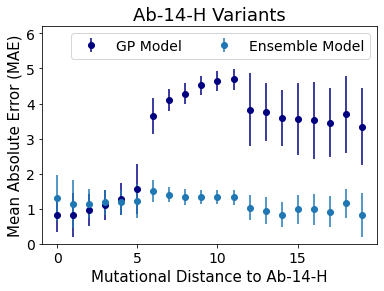

In [3]:
# Performed on sequences with at least 3 (out of 6 replicates) non-empty empirical 
# measurements and exclude sequences that are deemed poor binders without a reliable 
# empirical value.

plt.figure(figsize=(6, 4))
z1 = []
z2 = []
c1 = []
c2 = []
n = max(gen_data_measurement['mutation_dist'])+1
for d in range(0,n):
    tmp = gen_data_measurement[gen_data_measurement['mutation_dist']==d]
    x = np.array(tmp['exp'])
    y = np.array(tmp['gp_pred_mean'])
    z1.append(np.mean(np.abs(x-y)))
    c1.append(np.var(np.abs(x-y)))
    y = np.array(tmp['ensemble_pred_mean'])
    z2.append(np.mean(np.abs(x-y)))
    c2.append(np.var(np.abs(x-y)))
plt.rcParams['font.size'] = '15'
mpl.rcParams['xtick.labelsize'] = '14'
mpl.rcParams['ytick.labelsize'] = '14'
plt.errorbar(list(range(0,n)),z1, yerr = c1, fmt ='o',label='GP Model',color='navy')
plt.errorbar(list(range(0,n)),z2, yerr = c2, fmt ='o',label='Ensemble Model')
plt.xlabel('Mutational Distance to Ab-14-H')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend(fancybox=True,ncol=2,prop={'size': 14})
plt.ylim([0,6.2])
plt.title('Ab-14-H Variants')
plt.show()

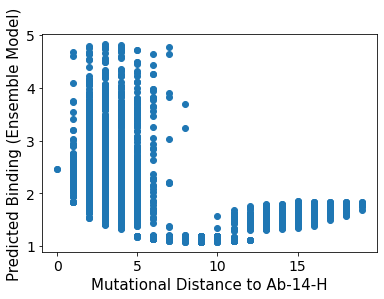

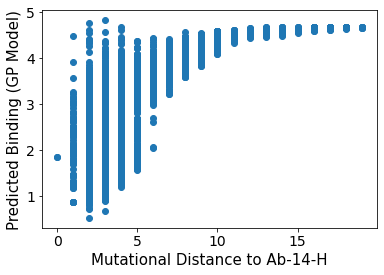

In [4]:
# Understand the distribution of the predicted binding for sequences excluded from the above MAE analysis
# Sequences that are deemed to be poor binders due to lack of sufficient empirical measurements

data_poor_binders = all_data.dropna(subset=['exp']) 

plt.scatter(data_poor_binders['mutation_dist'],data_poor_binders['ensemble_pred_mean'])
plt.xlabel('Mutational Distance to Ab-14-H')
plt.ylabel('Predicted Binding (Ensemble Model)')
plt.show()

plt.scatter(data_poor_binders['mutation_dist'],data_poor_binders['gp_pred_mean'])
plt.xlabel('Mutational Distance to Ab-14-H')
plt.ylabel('Predicted Binding (GP Model)')
plt.show()

# predicted binding vs sequence diversity (represented by the distance from the initial sequence Ab-14-H)
# Ensemble can extrapolate well far beyond the initial sequence, but at large mutational distance, the predicted binding can also go terribly wrong
# GP can't extrapolate as far as ensemble (a more conservative approach)

# Individual Libraries Performance 
Use PSSM as the baseline method

/state/partition1/slurm_tmp/59866814.0.0/ipykernel_74038/2858091302.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_lib['sample_method'] = lib
/state/partition1/slurm_tmp/59866814.0.0/ipykernel_74038/2858091302.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_lib['model'] = lib.split('_')[0]


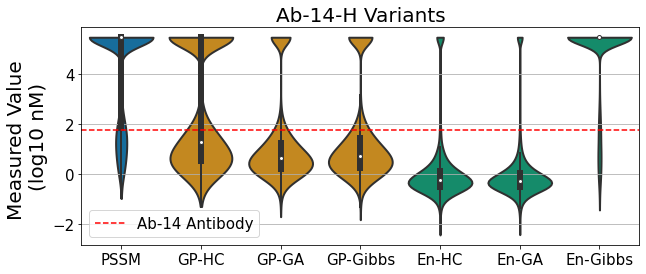

[array([0.09068627, 0.42598039, 0.61127451, 1.        ]), array([0.76421569, 0.53186275, 0.12598039, 1.        ]), array([0.76421569, 0.53186275, 0.12598039, 1.        ]), array([0.76421569, 0.53186275, 0.12598039, 1.        ]), array([0.08431373, 0.54313725, 0.41666667, 1.        ]), array([0.08431373, 0.54313725, 0.41666667, 1.        ]), array([0.08431373, 0.54313725, 0.41666667, 1.        ])]


In [5]:
# Distribution of individual libraries

# prepare data for the violin plot
tmp_data = data_present.copy()
tmp_data['exp'] = tmp_data['exp'].fillna(max_val) # impute the binding value 
lib_df_list = []
lib_list = ['PSSM','GP_HC','GP_Gen','GP_Gibbs','En_HC','En_Gen','En_Gibbs']
for lib in lib_list:
    tmp_lib = tmp_data[tmp_data[lib]]
    tmp_lib['sample_method'] = lib
    tmp_lib['model'] = lib.split('_')[0]
    lib_df_list.append(tmp_lib)
vertical_stack = pd.concat(lib_df_list, axis=0)

# plot violin plot
plt.figure(figsize=(10,4))
plt.rcParams['text.usetex'] = False
ax = sns.violinplot(x="sample_method", y="exp",data=vertical_stack,palette=colors,hue='model', inner="box",dodge=False,cut=0, linewidth=2)
ax.set_ylabel("Measured Value \n(log10 nM)", fontsize = 20)
ax.set_xlabel("", fontsize = 20)
x_label_dict = {'Random_Mutation':'Random \n Mutations',
                'PSSM':'PSSM',
               'GP_HC': 'GP-HC',
                'GP_Gen': 'GP-GA',
                'GP_Gibbs': 'GP-Gibbs',
               'En_HC': 'En-HC',
                'En_Gen': 'En-GA',
                'En_Gibbs': 'En-Gibbs'}
x_labels = [x_label_dict[t.get_text()] for t in ax.get_xticklabels()]
ax.set_xticklabels(x_labels)
ax.tick_params(labelsize=15)
ax.yaxis.grid(True)
plt.legend([],[], frameon=False)

# add candidate value
scat1 = plt.axhline(y=candidate_value, color='r', linestyle='--')
plt.legend([scat1],['Ab-14 Antibody'],loc = 'lower left',prop={'size': 15})
plt.title('Ab-14-H Variants',fontsize=20)
plt.show()

from matplotlib.collections import PolyCollection
violin_colors = []
for ind, violin in enumerate(ax.findobj(PolyCollection)):
    violin_colors.append(violin.get_facecolor()[0])
print(violin_colors)

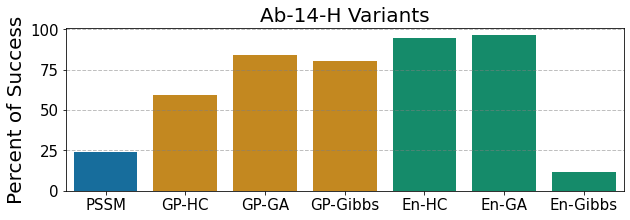

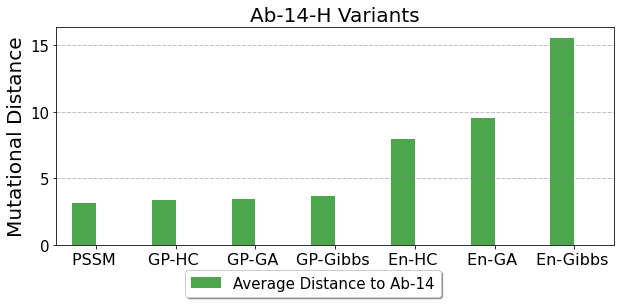

In [6]:
# Percent of success (percent of sequences that are better than Ab-14)
# Averaged mutational distance

sr = [] 
mute_dist = []
libs = ['PSSM', 'GP_HC', 'GP_Gen','GP_Gibbs','En_HC', 'En_Gen','En_Gibbs']
for lib in libs:
    tmp = data_present[data_present[lib]]
    a = len(tmp) # total number of sequences that were experimentally measured
    val = np.array(tmp.dropna(subset=['exp'])['exp']) 
    sr_tmp = sum(val<candidate_value)/a
    sr.append(sr_tmp)
    mute_dist_tmp = np.mean(tmp['mutation_dist'])
    mute_dist.append(mute_dist_tmp)

# plot percent of success
plt.figure(figsize=(10,3))
X_axis = np.arange(len(sr))
plt.bar(X_axis, np.array(sr)*100,color = violin_colors)
plt.xlim([-0.5,6.5])
plt.xticks(X_axis, ['PSSM','GP-HC','GP-GA','GP-Gibbs','En-HC','En-GA','En-Gibbs'],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Percent of Success', fontsize=20)
plt.title('Ab-14-H Variants',fontsize = 20)
plt.grid(color='grey', linestyle='--', linewidth=1, axis='y', alpha=0.5)
plt.show()

# plot averaged mutational distance
X = ['PSSM \n','GP-HC \n','GP-GA \n','GP-Gibbs \n','En-HC \n','En-GA \n','En-Gibbs \n']
dist_1 = np.array(mute_dist)
X_axis = np.arange(7)
plt.figure(figsize=(10,4))
bar1 = plt.bar(X_axis - 0.15, dist_1, 0.3,color = 'green',alpha=0.7,label = 'Average Distance to Ab-14')
plt.xticks(X_axis, X)
plt.xticks(fontsize=16)
plt.yticks([0,5,10,15],fontsize=15)
plt.xlim([-0.5,6.5])
plt.ylabel('Mutational Distance', multialignment='center',fontsize=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.46, -0.08),
          fancybox=True, shadow=True, ncol=2, fontsize=15)
plt.grid(color='grey', linestyle='--', linewidth=1, axis='y', alpha=0.5)
plt.title('Ab-14-H Variants',fontsize=20)
plt.show()

In [7]:
# best sequences based on empirical binding value 
print('Binding value and mutational distance from Ab-14 of the best sequence from each library')

libs = ['PSSM', 'GP_HC', 'GP_Gen','GP_Gibbs','En_HC', 'En_Gen','En_Gibbs']
for lib in libs:
    print(lib)
    tmp = gen_data_measurement[gen_data_measurement[lib]].sort_values(by=['exp']).head(1)
    aff_val = list(tmp['exp'])[0]
    mute_dist_val = list(tmp['mutation_dist'])[0]
    print('Binding val:', aff_val,'log10(nM)', 'and',(10**aff_val)*1000,'pM') # convert from log10 M to pM
    print('Mutataionl distance:', mute_dist_val)

Binding value and mutational distance from Ab-14 of the best sequence from each library
PSSM
Binding val: -0.96018264 log10(nM) and 109.60171756081783 pM
Mutataionl distance: 4
GP_HC
Binding val: -1.28250135 log10(nM) and 52.17934822467246 pM
Mutataionl distance: 3
GP_Gen
Binding val: -1.688614787 log10(nM) and 20.482606091284055 pM
Mutataionl distance: 4
GP_Gibbs
Binding val: -1.808519407 log10(nM) and 15.541058420283386 pM
Mutataionl distance: 4
En_HC
Binding val: -2.418323896 log10(nM) and 3.8165952372318706 pM
Mutataionl distance: 7
En_Gen
Binding val: -2.406354481 log10(nM) and 3.9232458046176553 pM
Mutataionl distance: 10
En_Gibbs
Binding val: -1.418775049 log10(nM) and 38.12632547355999 pM
Mutataionl distance: 15


# In silico library performance comparison

actual % of success [0.23824884792626727, 0.594332298136646, 0.842085450781103, 0.805450416351249]
estimated % of success [0.05422319181323505, 0.27467428954888257, 0.6911089181076715, 0.5828927239619448]


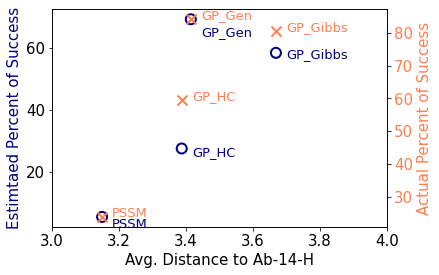

In [8]:
def compute_estimated_success_rate(pred_mean, pred_std):
    cdf = []
    for mu,sigma in list(zip(pred_mean, pred_std)):
        if sigma == 0:
            sigma = 2.220446049250313e-16
        cdf.append(NormalDist(mu=mu, sigma=sigma).cdf(candidate_value))
    rate_est = np.mean(cdf)
    return rate_est

sr = []
sr_est = []
mute_dist = []
libs = ['PSSM', 'GP_HC', 'GP_Gen','GP_Gibbs']
for lib in libs:
    # estimated percent of success
    tmp = data_present[data_present[lib]]
    sr_tmp = compute_estimated_success_rate(tmp['gp_pred_mean'], tmp['gp_pred_std'])
    sr_est.append(sr_tmp)
    # actual percent of success
    a = len(tmp) # total number of sequences that were experimentally measured
    val = np.array(tmp.dropna(subset=['exp'])['exp']) 
    sr_tmp = sum(val<candidate_value)/a
    sr.append(sr_tmp)
    # averaged mutational distance
    mute_dist.append(np.mean(tmp['mutation_dist']))
print('actual % of success',sr)
print('estimated % of success',sr_est)

# plot
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
success_rate_act = np.array(sr)*100
success_rate_est = np.array(sr_est)*100
# estimated percent of success and average mutational distance per library
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.set_xlabel('Avg. Distance to Ab-14-H', color='k',fontsize=15)
ax1.set_ylabel('Estimtaed Percent of Success', color='navy',fontsize=15)
ax1.scatter(mute_dist,success_rate_est,facecolors='none', edgecolors='navy',s=100,linewidths=2)
ax1.tick_params(axis='y', labelcolor='k')
ax1.set_xlim([3,4])
# actual percent of success and average mutational distance per library
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Actual Percent of Success', color='coral',fontsize=15)  # we already handled the x-label with ax1
ax2.scatter(mute_dist,success_rate_act,marker='x',color='coral',s=100,linewidths=2)
ax2.tick_params(axis='y', labelcolor='coral')
ax2.set_xlim([3,4])
# adjusting label locations
label = libs
x_offset = [0.03]*4
y_offset = [15,15,10,14]
ind = 0
for x,y in zip(mute_dist,success_rate_est):
    ax2.text(x+x_offset[ind],y+y_offset[ind], label[ind], color='navy',fontsize = 13)
    ind+=1
x_offset = [0.03]*4
y_offset = [0,0,0,0]
ind = 0
for x,y in zip(mute_dist,success_rate_act):
    ax2.text(x+x_offset[ind],y+y_offset[ind], label[ind], color='coral',fontsize = 13)
    ind+=1
plt.show()

actual % of success [0.23824884792626727, 0.9433008982035929, 0.9608286252354049, 0.11518753843000615]
estimated % of success [0.11930348590090645, 0.727475392815856, 0.7356601051273411, 0.5402724939678227]


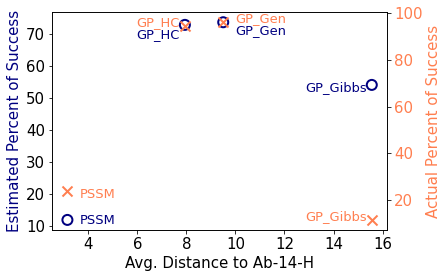

In [9]:
sr = []
sr_est = []
mute_dist = []
libs = ['PSSM', 'En_HC', 'En_Gen','En_Gibbs']
for lib in libs:
    # estimated percent of success
    tmp = data_present[data_present[lib]]
    sr_tmp = compute_estimated_success_rate(tmp['ensemble_pred_mean'], tmp['ensemble_pred_std'])
    sr_est.append(sr_tmp)
    # actual percent of success
    a = len(tmp) # total number of sequences that were experimentally measured
    val = np.array(tmp.dropna(subset=['exp'])['exp']) 
    sr_tmp = sum(val<candidate_value)/a
    sr.append(sr_tmp)
    # averaged mutational distance
    mute_dist.append(np.mean(tmp['mutation_dist']))
print('actual % of success',sr)
print('estimated % of success',sr_est)

# plot
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
success_rate_act = np.array(sr)*100
success_rate_est = np.array(sr_est)*100
# estimated percent of success and average mutational distance per library
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.set_xlabel('Avg. Distance to Ab-14-H', color='k',fontsize=15)
ax1.set_ylabel('Estimated Percent of Success', color='navy',fontsize=15)
ax1.scatter(mute_dist,success_rate_est,facecolors='none', edgecolors='navy',s=100,linewidths=2)
ax1.tick_params(axis='y', labelcolor='k')
# actual percent of success and average mutational distance per library
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Actual Percent of Success', color='coral',fontsize=15)  # we already handled the x-label with ax1
ax2.scatter(mute_dist,success_rate_act,marker='x',color='coral',s=100,linewidths=2)
ax2.tick_params(axis='y', labelcolor='coral')
# adjusting label locations
x_offset = [0.5,-2,0.5,-2.7]
y_offset = [-14,-5,-5,55]
ind = 0
for x,y in zip(mute_dist,success_rate_act):
    ax2.text(x+x_offset[ind],y+y_offset[ind], label[ind], color='navy',fontsize = 13)
    ind+=1
ind = 0
x_offset = [0.5,-2,0.5,-2.7]
y_offset = [-3,0,0,0]
for x,y in zip(mute_dist,success_rate_act):
    ax2.text(x+x_offset[ind],y+y_offset[ind], label[ind], color='coral',fontsize = 13)
    ind+=1
plt.show()
